In [14]:
# Cell 1: imports

import numpy as np
import pandas as pd

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import (
    accuracy_score,
    classification_report,
    confusion_matrix
)

In [15]:
# Cell 2: load full multi-gateway dataset

data_path = "../LoRaWAN Localization - Advanced Files/gw0_kalman_filtered.csv"
df_gw0 = pd.read_csv(data_path)

print(df_gw0.shape)
df_gw0.head()

(2079534, 24)


,time,device_id,co2,humidity,pm25,pressure,temperature,rssi,snr,SF,...,distance,c_walls,w_walls,exp_pl,n_power,esp,filtered_rssi,kf_rssi,exp_pl_filtered,exp_pl_kf
0,2024-10-01 00:03:24.732142+00:00,ED0,451.0,42.73,0.41,313.28,20.72,-43.0,11.8,10,...,10,0,0,60.26,-55.077855,-43.277855,-43.000000,-43.000000,60.260000,60.260000
1,2024-10-01 00:04:24.782213+00:00,ED0,448.0,42.74,0.56,313.34,20.75,-42.0,9.0,10,...,10,0,0,59.26,-51.514969,-42.514969,-42.496614,-42.660661,59.756614,59.920661
2,2024-10-01 00:05:24.836728+00:00,ED0,455.0,42.73,0.34,313.32,20.74,-44.0,12.8,10,...,10,0,0,61.26,-57.022142,-44.222142,-43.008820,-43.010079,60.268820,60.270079
3,2024-10-01 00:06:24.874519+00:00,ED0,461.0,42.73,0.34,313.34,20.75,-45.0,11.2,10,...,10,0,0,62.26,-56.517549,-45.317549,-43.529577,-43.438696,60.789577,60.698696
4,2024-10-01 00:07:24.720724+00:00,ED0,456.0,42.77,0.50,313.36,20.74,-46.0,11.8,9,...,10,0,0,63.26,-58.077855,-46.277855,-44.062439,-43.915996,61.322439,61.175996


In [16]:
# Cell 4: define fingerprint features and label

feature_cols = [
    "rssi",
    "snr",
    "co2",
    "humidity",
    "pm25",
    "pressure",
    "temperature",
    "SF",
    "frequency",
    "toa",
]

label_col = "device_id"

# Drop rows with any NaN in the chosen features
before = df_gw0.shape[0]
df_gw0 = df_gw0.dropna(subset=feature_cols + [label_col])
after = df_gw0.shape[0]

print(f"Dropped {before - after} rows with NaNs, kept {after}")


Dropped 0 rows with NaNs, kept 2079534


In [17]:
# Cell 5: encode device_id labels and build feature matrix

le = LabelEncoder()
df_gw0["label_encoded"] = le.fit_transform(df_gw0[label_col])

X = df_gw0[feature_cols].values
y = df_gw0["label_encoded"].values

print("Classes:", le.classes_)
print("X shape:", X.shape, "y shape:", y.shape)

# Cell 5b: parse time and sort chronologically

df_gw0["time"] = pd.to_datetime(df_gw0["time"])
df_gw0 = df_gw0.sort_values("time").reset_index(drop=True)

print("Time range:", df_gw0["time"].min(), "→", df_gw0["time"].max())


Classes: ['ED0' 'ED1' 'ED2' 'ED3' 'ED4' 'ED5']
X shape: (2079534, 10) y shape: (2079534,)
Time range: 2024-10-01 00:01:07.420593+00:00 → 2025-09-30 23:59:55.971870+00:00


In [18]:
# Cell 6 (time-based split instead of random split)

# 80% of samples in *earlier* time, 20% in *later* time
split_idx = int(0.8 * len(df_gw0))

train_df = df_gw0.iloc[:split_idx]
test_df  = df_gw0.iloc[split_idx:]

print("Train rows:", train_df.shape[0])
print("Test rows :", test_df.shape[0])

# Build X, y from the two dataframes
X_train = train_df[feature_cols].values
y_train = train_df["label_encoded"].values

X_test  = test_df[feature_cols].values
y_test  = test_df["label_encoded"].values

# Optional: check label distribution drift
print("\nTrain label distribution:")
print(train_df["device_id"].value_counts(normalize=True))

print("\nTest label distribution:")
print(test_df["device_id"].value_counts(normalize=True))


Train rows: 1663627
Test rows : 415907

Train label distribution:
device_id
ED5    0.171365
ED2    0.167613
ED0    0.166681
ED4    0.165014
ED1    0.164825
ED3    0.164503
Name: proportion, dtype: float64

Test label distribution:
device_id
ED5    0.168499
ED0    0.167968
ED2    0.166956
ED4    0.166797
ED1    0.166763
ED3    0.163017
Name: proportion, dtype: float64


In [19]:
# Cell 7: train RandomForest on GW0 fingerprints

rf = RandomForestClassifier(
    n_estimators=300,
    max_depth=None,
    min_samples_split=2,
    min_samples_leaf=1,
    n_jobs=-1,
    random_state=42,
    class_weight="balanced_subsample",  # helps if classes are imbalanced
)

rf.fit(X_train, y_train)


RandomForestClassifier(class_weight='balanced_subsample', n_estimators=300,
                       n_jobs=-1, random_state=42)

In [20]:
# Cell 8: predictions and accuracy metrics

y_pred = rf.predict(X_test)

acc = accuracy_score(y_test, y_pred)
print(f"Overall accuracy (test set): {acc:.3f}")

print("\nClassification report (per ED):\n")
print(
    classification_report(
        y_test,
        y_pred,
        target_names=le.classes_
    )
)

Overall accuracy (test set): 0.699

Classification report (per ED):

              precision    recall  f1-score   support

         ED0       0.53      0.54      0.53     69859
         ED1       0.52      0.49      0.51     69358
         ED2       0.72      0.46      0.56     69438
         ED3       0.57      0.82      0.68     67800
         ED4       0.93      0.96      0.94     69372
         ED5       0.98      0.92      0.95     70080

    accuracy                           0.70    415907
   macro avg       0.71      0.70      0.70    415907
weighted avg       0.71      0.70      0.70    415907



In [21]:
# Cell 9: confusion matrix

cm = confusion_matrix(y_test, y_pred)
cm_df = pd.DataFrame(
    cm,
    index=[f"true_{c}" for c in le.classes_],
    columns=[f"pred_{c}" for c in le.classes_]
)

cm_df


,pred_ED0,pred_ED1,pred_ED2,pred_ED3,pred_ED4,pred_ED5
true_ED0,37666,27720,443,3659,362,9
true_ED1,31519,34291,82,2915,93,458
true_ED2,1138,579,31998,34651,849,223
true_ED3,639,3091,8061,55911,87,11
true_ED4,41,39,2210,29,66555,498
true_ED5,0,4,1637,164,3800,64475


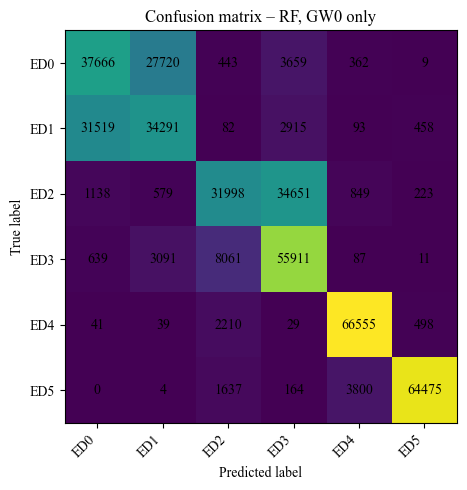

In [22]:
# Cell 10: plot confusion matrix

import matplotlib.pyplot as plt
import numpy as np

fig, ax = plt.subplots(figsize=(6, 5))

# Show confusion matrix as an image
im = ax.imshow(cm)

# Tick labels: ED0..ED5
classes = le.classes_
ax.set_xticks(np.arange(len(classes)))
ax.set_yticks(np.arange(len(classes)))
ax.set_xticklabels(classes, rotation=45, ha="right")
ax.set_yticklabels(classes)

ax.set_xlabel("Predicted label")
ax.set_ylabel("True label")
ax.set_title("Confusion matrix – RF, GW0 only")

# Write the counts inside the cells
for i in range(cm.shape[0]):
    for j in range(cm.shape[1]):
        ax.text(j, i, cm[i, j],
                ha="center", va="center")

plt.tight_layout()
plt.show()

In [23]:
# Cell 10: feature importance to see which signals matter most

importances = rf.feature_importances_
fi = pd.Series(importances, index=feature_cols).sort_values(ascending=False)
fi


rssi           0.424710
temperature    0.136410
pm25           0.130641
humidity       0.114499
pressure       0.085438
co2            0.058009
snr            0.035447
frequency      0.006405
toa            0.004369
SF             0.004072
dtype: float64